# Full Workbench disease network
- Pull studies from API with REFMET
    - Combine assays?
- Threshold on number of REFMET compounds?
- Build bipartite graph with only overlapping compounds

In [256]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import networkx as nx
from networkx.algorithms import bipartite
import itertools

In [3]:
# get disease associations
disease_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/disease'
disease_assoc = requests.get(disease_url)
disease_json = disease_assoc.json()

In [4]:
disease_assoc_df = pd.DataFrame.from_dict(disease_json, orient='index')

In [5]:
disease_assoc_df.to_csv('Disease_association_Workbench.csv')

In [292]:
disease_assoc_df = pd.read_csv('Disease_association_Workbench.csv', index_col=0)

In [293]:
disease_assoc_df['Disease'].value_counts()

Disease
Cancer                     402
Diabetes                   103
Obesity                     63
Malaria                     45
Environmental exposure      43
                          ... 
Psoriasis                    1
Valley fever                 1
Urinary tract infection      1
Heat stroke                  1
Maternal Hypoxemia           1
Name: count, Length: 201, dtype: int64

In [21]:
disease_assoc_df['Disease'].value_counts().head(10).reset_index()

,Disease,count
0,Cancer,402
1,Diabetes,103
2,Obesity,63
3,Malaria,45
4,Environmental exposure,43
5,Eye disease,37
6,Fatty liver disease,37
7,Heart disease,33
8,Tuberculosis,28
9,Spinal cord injury,26


C:\Users\cw2019\AppData\Local\Temp\ipykernel_32988\3327851847.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='count', ylabel='Disease'>

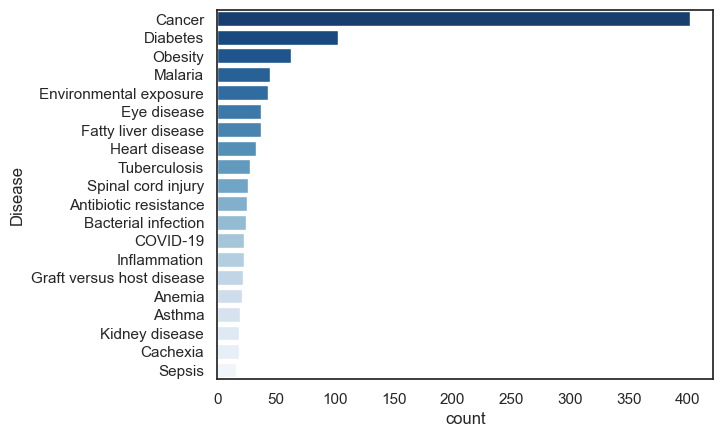

In [26]:
# plot top 10 diseases
sns.set(
    style='white'
)
sns.barplot(
    data=disease_assoc_df['Disease'].value_counts().head(20).reset_index(),
    x='count',
    y='Disease',
    palette='Blues_r'
)

## Download all study data - not needed
Only REFMET are required

In [6]:
named_met_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/named_metabolites/'
named_met_dat = requests.get(named_met_url)
named_met_json = named_met_dat.json()
named_met_df = pd.DataFrame.from_dict(named_met_json, orient='index')

In [7]:
named_met_df.to_csv('Named_metabolites_Workbench.csv')

In [6]:
named_met_df = pd.read_csv('Named_metabolites_Workbench.csv', index_col=0)

In [7]:
named_met_df.sort_values(by='num_metabolites').head()


,study_id,study_title,institute,analysis_id,analysis_type,units,num_metabolites,details,species
270,ST000287,Energetics in dystrophic muscle,University of Florida,AN000457,MS,pmol/mg dry powder,1,NADH Positive mode,Mus musculus
1179,ST001069,Evaluation of Seryl-leucine core 1 O-glycosyla...,Colorado State University,AN001750,MS,counts,1,Reversed phase POSITIVE ION MODE/TOF,Homo sapiens
2779,ST002702,A targeted metabolomics approach for sepsis-in...,Asan Medical Center,AN004381,MS,ug/uL,1,Reversed phase NEGATIVE ION MODE,Homo sapiens
2192,ST002122,Functional metabolic molecules were identified...,"Shanghai Center for Systems Biomedicine, Shang...",AN003475,MS,counts,1,Reversed phase NEGATIVE ION MODE,Homo sapiens
542,ST000543,High Resolution orbittrap Mass Spectrometer to...,Mayo Clinic,AN000825,MS,mole percent enrichment,1,UPLC POSITIVE ION MODE,Homo sapiens


In [8]:
# filter for at least 100 named mets
named_met_df['num_metabolites'] = named_met_df['num_metabolites'].astype(int)
named_met_df_filt = named_met_df[named_met_df['num_metabolites'] >= 500]

In [39]:
named_met_df_filt

,study_id,study_title,institute,analysis_id,analysis_type,units,num_metabolites,details,species
12,ST000005,Timecourse on RAW 264.7 cells treated with Kdo...,LIPID MAPS,AN000012,MS,pmol/ug DNA,546,Combined analysis,Mus musculus
25,ST000016,NPM-ALK metabolic regulation,University of Michigan,AN000033,MS,Peak area,500,LC/MS positive ion mode,Homo sapiens
33,ST000041,High PUFA diet in humans,University of Michigan,AN000063,MS,Counts,534,MS positive ion mode,Homo sapiens
37,ST000044,Pilot experiment looking for the existence of ...,University of Michigan,AN000068,MS,Counts,778,MS positive ion mode,Homo sapiens
47,ST000047,Identification of altered metabolic pathways i...,Mayo Clinic,AN000080,MS,Raw MS Intensities,557,MS positive ion mode/C18,Homo sapiens
...,...,...,...,...,...,...,...,...,...
3264,ST003241,Lipidomic analysis of lung from Gclc WT and wh...,University of Rochester Medical Center,AN005309,MS,Normalized to the median value of total lipid ...,1665,Reversed phase POSITIVE ION MODE,Mus musculus
3265,ST003241,Lipidomic analysis of lung from Gclc WT and wh...,University of Rochester Medical Center,AN005310,MS,Normalized to the median value of total lipid ...,647,Reversed phase NEGATIVE ION MODE,Mus musculus
3266,ST003242,Lipidomic analysis of kidney from Gclc WT and ...,University of Rochester Medical Center,AN005311,MS,Normalized to the median value of total lipid ...,1349,Reversed phase POSITIVE ION MODE,Mus musculus
3270,ST003250,Lipidomic analysis of Axon Regeneration in Xen...,University of Miami,AN005323,MS,peak area,967,Reversed phase POSITIVE ION MODE,Xenopus laevis


In [271]:
studies = list(set(named_met_df_filt['study_id'].tolist()))[0:50]
studies_assays = dict.fromkeys(studies)

In [10]:

# Get assays for each study
for s in tqdm(studies):
    # progress bar
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/analysis'
    resp = requests.get(base_url.replace('repl', s)).json()
    if list(resp.keys())[0] != '1':
        resp_series = pd.Series(resp)
        studies_assays[s] = [resp_series['analysis_id']]
    else:
        resp_df = pd.DataFrame.from_dict(resp).T
        studies_assays[s] = resp_df['analysis_id'].tolist()

100%|██████████| 274/274 [04:26<00:00,  1.03it/s]


In [ ]:
# # download all assays per study
# for study in studies:
#     print(study)
#     base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'
#     #check if directory exists
#     if not os.path.isdir('Studies_all/'+study):
#         os.mkdir('Studies_all/'+study)

#         for assay in studies_assays[study]:
#             url = base_url + assay + '/datatable/file'
#             print(url)
#             pd.read_csv(url, sep='\t').to_csv('Studies_all/'+study+'/'+f'{assay}.csv', index=False)
#     else:
#         pass

Concatenate all assays and extract REFMET names

In [248]:
studies[0]

'ST000310'

In [201]:
def get_refmets(study_id):
    mets_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/metabolites'
    mets = requests.get(mets_url.replace('repl', study_id)).json()
    mets_df = pd.DataFrame.from_dict(mets, orient='index')
    refmets = set(mets_df['refmet_name'].tolist())
    return refmets

Now we need to find a computationally efficient way to store all REFMETS from each study and then find the overlapping REFMETS between studies.

Ideas:
- dict with refmets as keys. Values are lists of studies that contain that refmet
- Matrix with studies as rows and refmets as columns. 1 if refmet is in study, 0 otherwise
    - Convert to biadj matrix


In [273]:
refmets_all = []
studies_without_refmets = []
# connections_all = []
for s in tqdm(studies):
    try:
        refmets_all.append(get_refmets(s))
    except KeyError:
        print(s)
        studies_without_refmets.append(s)
        continue
    # connections_all.append(get_refmets(s)[1])


 38%|███▊      | 19/50 [02:33<04:30,  8.72s/it]

ST001636


100%|██████████| 50/50 [04:35<00:00,  5.51s/it]


In [274]:
# remove studies without refmets from the study list
studies = [s for s in studies if s not in studies_without_refmets]

In [275]:
len(refmets_all)

49

## Create adjacency matrix

In [277]:
adj_mat.shape

(49, 49)

In [276]:
# initialise empty numpy array
adj_mat = np.zeros((len(studies), len(studies)))

# fill in adjacency matrix
combinations = list(itertools.combinations(studies, 2))
for c in combinations:
    i = studies.index(c[0])
    j = studies.index(c[1])
    adj_mat[i, j] = len(refmets_all[i].intersection(refmets_all[j]))
    adj_mat[j, i] = len(refmets_all[i].intersection(refmets_all[j]))



In [278]:
adj_df = pd.DataFrame(adj_mat, index=studies, columns=studies)

In [317]:
# remove studies with no connection to anything
adj_df = adj_df[adj_df.sum(axis=1) > 0]

In [318]:
adj_df.shape

(49, 49)

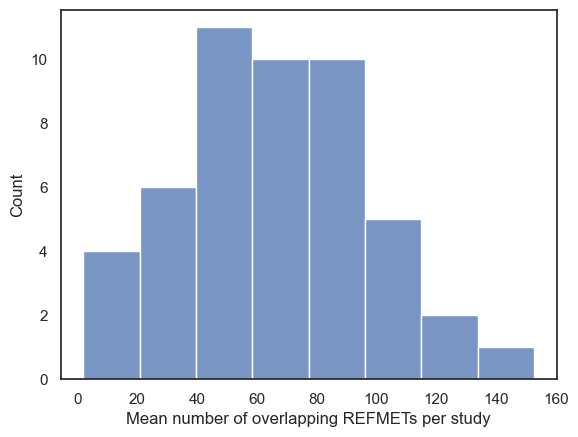

In [323]:
# mean number of connections
sns.histplot(
    data=adj_df.mean()
)
plt.xlabel('Mean number of overlapping REFMETs per study')
plt.show()

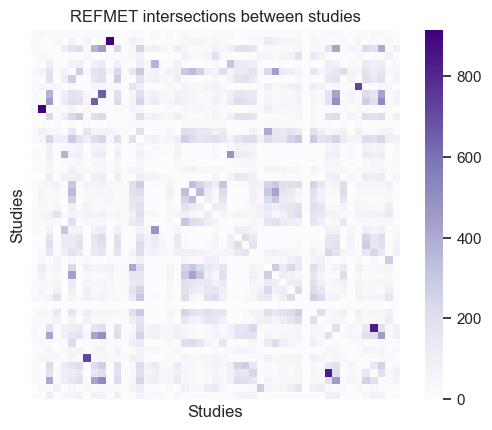

In [283]:
sns.set(
    style='white'
)
ax = sns.heatmap(
    data=adj_df,
    square=True,
    cmap='Purples',
    yticklabels=False,
    xticklabels=False
)

ax.set_title('REFMET intersections between studies')
ax.set_xlabel('Studies')
ax.set_ylabel('Studies')
plt.show()

### Nx network and disease associations

In [285]:
adj_mat_edgelist = adj_df.melt(ignore_index=False).reset_index()

In [289]:
adj_mat_edgelist.head()

,index,variable,value
0,ST000310,ST000310,0.0
1,ST001915,ST000310,39.0
2,ST001403,ST000310,21.0
3,ST002880,ST000310,12.0
4,ST000047,ST000310,11.0


In [297]:
disease_assoc_df.head()

,Study ID,Disease
1,ST000007,Bacterial infection
2,ST000010,Cancer
3,ST000020,Osteoarthritis
4,ST000022,Osteoarthritis
5,ST000026,Antibiotic resistance


In [299]:
disease_assoc_df[disease_assoc_df['Study ID'] == 'ST000310']

,Study ID,Disease
91,ST000310,Lupus


In [309]:
disease_assoc_df

,Study ID,Disease
1,ST000007,Bacterial infection
2,ST000010,Cancer
3,ST000020,Osteoarthritis
4,ST000022,Osteoarthritis
5,ST000026,Antibiotic resistance
...,...,...
1556,ST003243,Oxidative stress; Stress
1557,ST003249,Alzheimers disease
1558,ST003250,Glaucoma; Eye disease
1559,ST003251,Environmental exposure


In [312]:
disease_net = nx.from_pandas_edgelist(
    df=disease_assoc_df,
    source='Study ID',
    target='Disease'
)

In [314]:
# add disease assoc as node attribute
disease_dict = dict(zip(disease_assoc_df['Study ID'], disease_assoc_df['Disease']))
disease_net.add_nodes_from([(node, {'Disease': attr}) for (node, attr) in disease_dict.items()])


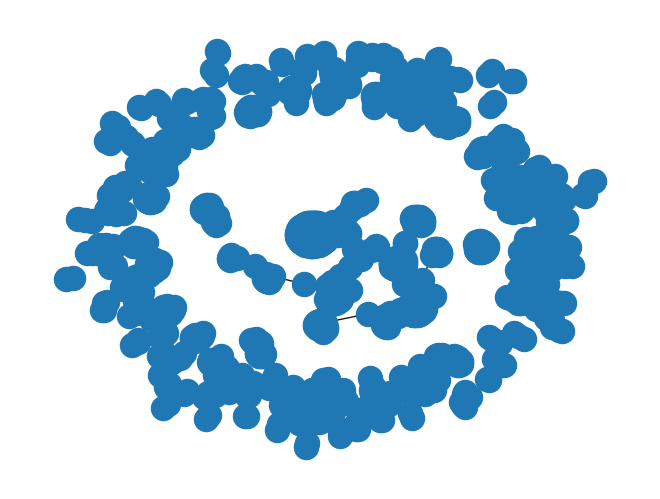

In [325]:
# quick visualisation
nx.draw(
    disease_net,
    pos=nx.spring_layout(disease_net))

In [324]:
# export network to graphml
nx.write_graphml(disease_net, 'WorkBench_full_REFMET_overlap.graphml')

## Create bi-adjacency matrix (bipartite graph)
- Shows exactly which refmets are shared between studies

In [245]:
studies = studies[0:11]

In [207]:
unique_compounds = sorted(set(compound for lst in refmets_all for compound in lst))

# Create a compound index for quick lookup
compound_index = {compound: idx for idx, compound in enumerate(unique_compounds)}

# Number of studies and compounds
num_studies = len(studies)
num_compounds = len(unique_compounds)

# Initialize the presence-absence matrix
presence_absence_matrix = np.zeros((num_studies, num_compounds), dtype=int)

# Fill the matrix
for study_idx, cpd_list in enumerate(refmets_all):
    for cpd in cpd_list:
        compound_idx = compound_index[cpd]
        presence_absence_matrix[study_idx, compound_idx] = 1

df = pd.DataFrame(presence_absence_matrix, index=studies, columns=unique_compounds)
df = df.drop(columns=[''])
df

,"(1S,2S)-3-Oxo-2-pentyl-cyclopentanebutanoic acid",(2-Chlorophenyl)diphenylmethane,"(E)-2,3-Dihydroxybut-2-enedioic acid",(E)-3-(4-Hydroxyphenyl)-2-propenal,"(E,E)-2,4-Octadienal",(R)-Pantoic acid,(S)-Homostachydrine,"1,2,3-Trihydroxybenzene","1,2,4-Trihydroxybenzene","1,3-Diaminopropane",...,p-Aminobenzoic acid,p-Hydroxyfelbamate,sn-Glycero-3-phosphate,sn-Glycero-3-phosphocholine,sn-Glycero-3-phosphoglycerol,trans-Aconitic acid,trans-Anethole,trans-Cinnamic acid,"trans-Cyclohexane-1,2-diol",trans-Ferulic acid
ST000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ST000016,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,1
ST000041,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,1
ST000044,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,1,1
ST000047,1,1,1,1,1,0,0,1,1,1,...,1,1,0,0,1,1,1,0,0,0
ST000076,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ST000106,0,0,0,0,0,1,1,0,0,0,...,1,0,1,1,0,1,0,1,1,1
ST000110,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ST000110,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ST000113,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [208]:
# drop columns where the sum is less than 2 - there will be a disconnected graph
df = df.loc[:, df.sum(axis=0) > 1]

In [209]:
df.shape

(11, 1554)

In [210]:
biadj_edgelist = df.melt(ignore_index=False).reset_index()

In [211]:
biadj_edgelist

,index,variable,value
0,ST000005,(S)-Homostachydrine,0
1,ST000016,(S)-Homostachydrine,1
2,ST000041,(S)-Homostachydrine,0
3,ST000044,(S)-Homostachydrine,0
4,ST000047,(S)-Homostachydrine,0
...,...,...,...
17089,ST000106,trans-Ferulic acid,1
17090,ST000110,trans-Ferulic acid,0
17091,ST000110,trans-Ferulic acid,0
17092,ST000113,trans-Ferulic acid,0


In [212]:
biadj_edgelist_connect = biadj_edgelist[biadj_edgelist['value'] == 1]
biadj_edgelist_tuples = list(zip(biadj_edgelist_connect['index'], biadj_edgelist_connect['variable']))

In [240]:
B = nx.Graph()
bipartite_nodes = studies
bipartite_edges = set(biadj_edgelist['variable'].tolist())
B.add_nodes_from(bipartite_nodes, bipartite=1)
B.add_nodes_from(bipartite_edges, bipartite=0)
B.add_edges_from(biadj_edgelist_tuples)


In [241]:
nx.is_bipartite(B)

True

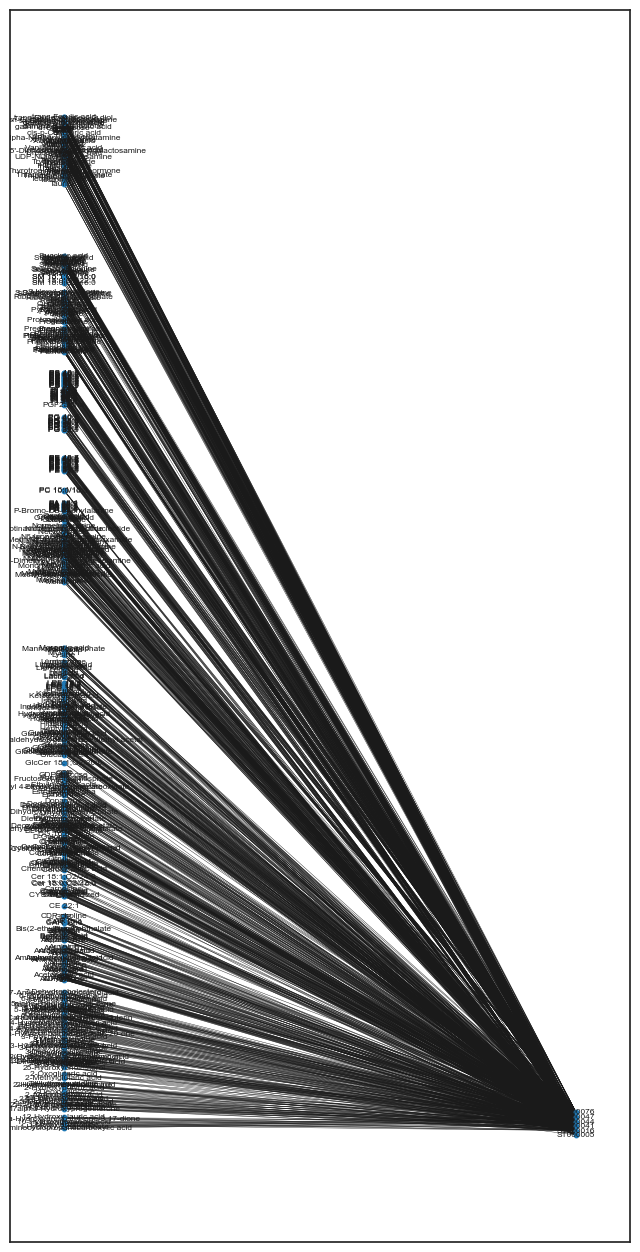

In [186]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(studies, unique_compounds),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

In [215]:
# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(B)
color_map = []
labels = {}
for node in B.nodes:
    if node in bipartite_nodes:
        print(node)
        color_map.append('red')
        # labels[node] = study_labels[node]
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    B,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
# nx.draw_networkx_labels(covid_bpt, pos, labels,
#                         bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
#                         font_size=8,
#                         font_color='black')

plt.show()

KeyboardInterrupt: 

Total number of overlapping REFMETS between each study
- 

In [243]:
bipartite_nodes

['ST000005',
 'ST000016',
 'ST000041',
 'ST000044',
 'ST000047',
 'ST000076',
 'ST000106',
 'ST000110',
 'ST000110',
 'ST000113',
 'ST000114']

In [242]:
biadj_mat = nx.bipartite.biadjacency_matrix(B, row_order=bipartite_nodes, column_order=unique_compounds).toarray()

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(bipartite_nodes), columns=list(bipartite_nodes))

NetworkXError: Ambiguous ordering: `row_order` contained duplicates.

In [238]:
adj_mat

,ST000005,ST000016,ST000041,ST000044,ST000047,ST000076
ST000005,271,6,20,22,8,103
ST000016,6,422,331,336,87,35
ST000041,20,331,427,363,92,43
ST000044,22,336,363,495,103,51
ST000047,8,87,92,103,126,18
ST000076,103,35,43,51,18,306


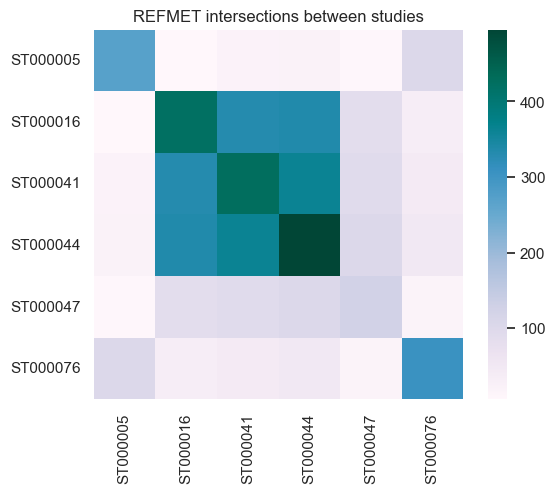

In [239]:
sns.set(
    style='white'
)
ax = sns.heatmap(
    data=adj_mat,
    square=True,
    cmap='PuBuGn',
)

ax.set_title('REFMET intersections between studies')
plt.show()